In [10]:
from sklearn.datasets import fetch_openml
# LogisticRegression uses batch gradient descent, but SGDClassifier uses one sample at a time (or small batch)
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
    						precision_score, recall_score, f1_score, precision_recall_curve, \
                            roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# The following code fetches the MNIST dataset from OpenML.org
mnist = fetch_openml('mnist_784', as_frame=False)
type(mnist)

sklearn.utils._bunch.Bunch

In [3]:
X, y = mnist.data, mnist.target

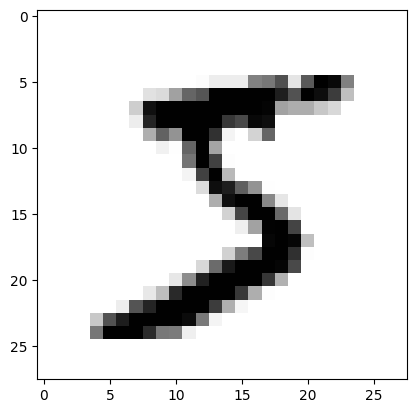

Label: 5


In [4]:
image0 = X[0].reshape(28, 28)
# we use cmap="binary" to get a grayscale color map where 0 is white and 255 is black
plt.imshow(image0, cmap='binary')
plt.show()
print('Label:', y[0])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Binary Classification (5-detector)

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
np.unique(y_train_5, return_counts=True)

(array([False,  True]), array([50950,  5050], dtype=int64))

In [8]:
sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96721487, 0.95714362, 0.96849887])

Generally, '**accuracy**' is not the preferred performance measure in classification, especially in skewed datasets (some classes are much more frequent than others)

For example, in the cell above if we'll get a close accuracy if we trained a dummy classifier that prints False all the time!

In [11]:
# Just like the cross_val_score() function, cross_val_predict() performs k-fold cross-validation, 
# but instead of returning the evaluation scores, it returns the predictions made on each test fold.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

In [12]:
confusion_matrix(y_train_5, y_train_pred)

array([[50550,   400],
       [ 1600,  3450]], dtype=int64)

In [13]:
accuracy_score(y_train_5, y_train_pred)

0.9642857142857143

In [14]:
precision_score(y_train_5, y_train_pred)

0.8961038961038961

In [15]:
recall_score(y_train_5, y_train_pred)

0.6831683168316832

In [16]:
f1_score(y_train_5, y_train_pred)

0.7752808988764045

In [17]:
print(classification_report(y_train_5, y_train_pred))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     50950
        True       0.90      0.68      0.78      5050

    accuracy                           0.96     56000
   macro avg       0.93      0.84      0.88     56000
weighted avg       0.96      0.96      0.96     56000



# Precision/Recall Curve (PR Curve)

In [18]:
# Instead of using X_test, we may create a dev. set or use cross validation
# sgd_clf.fit(X_train, y_train_5)
# y_scores = sgd_clf.predict_proba(X_test)

# This gives the raw scores, not probabilities
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [19]:
# This is a simple and fast way to convert decision scores to probabilities, 
# but this isn't reliable - it's more of a hack
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))
# y_scores = sigmoid(y_scores)

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
f1_scores = 2 / ((1 / precisions) + (1 / recalls))

C:\Users\moham\AppData\Local\Temp\ipykernel_12292\3886171906.py:8: RuntimeWarning: divide by zero encountered in divide
  f1_scores = 2 / ((1 / precisions) + (1 / recalls))


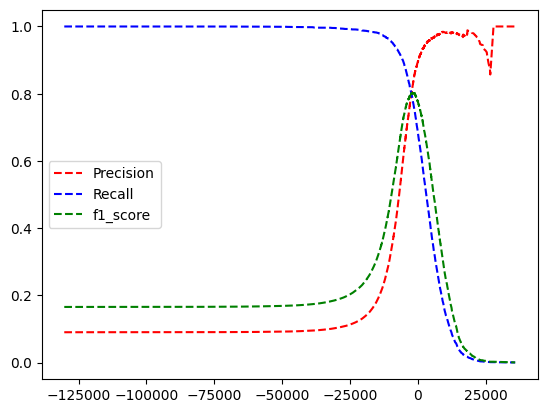

In [ ]:
plt.plot(thresholds, precisions[:-1], 'r--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'b--', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'g--', label='f1_score')
plt.legend()
plt.show()

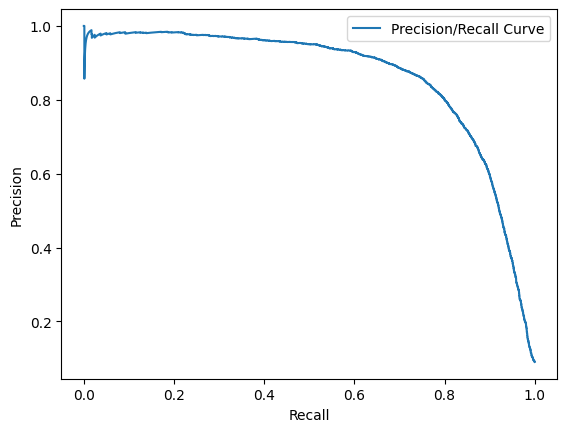

In [ ]:
plt.plot(recalls, precisions, label='Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
# threshold value is increasing as we move to the right side of the graph

In [20]:
best_f1_score = f1_scores.max()
print(best_f1_score)

best_threshold_idx = f1_scores.argmax()
best_threshold = thresholds[best_threshold_idx]
print(best_threshold)

0.8025266645956302
-1585.2266161336026


# ROC Curve & AUC

> It's an another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the **true positive rate** (another name
for recall) against the **false positive rate** (FPR). The FPR (also called the fall-out) is the
ratio of negative instances that are incorrectly classified as positive (FP / (FP + TN)). It is equal to 1 –
the true negative rate (TNR), which is the ratio of negative instances that are correctly
classified as negative. The TNR is also called specificity. *Hence, the ROC curve plots
sensitivity (recall) versus 1 – specificity*.

A good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the **area under the curve (AUC)**. A
perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier
will have a ROC AUC equal to 0.5.

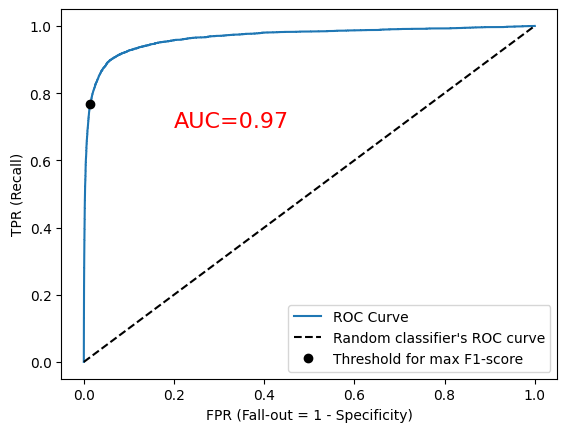

In [21]:
# generates thresholds different from the ones that are generated by `precision_recall_curve`
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# `argmax()` find the index of the 1st True value 
best_threshold_idx2 = (thresholds <= best_threshold).argmax()

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve")
plt.plot(fpr[best_threshold_idx2], tpr[best_threshold_idx2], 'ko', label='Threshold for max F1-score')

plt.text(x=0.2, y=0.7, s=f'AUC={roc_auc_score(y_train_5, y_scores):.2f}', fontsize=16, color='red')

plt.legend()
plt.xlabel('FPR (Fall-out = 1 - Specificity)')
plt.ylabel('TPR (Recall)')
plt.show()
# threshold value is decreasing as we move to the right side of the graph

# Multi-class Classification

Sciket-learn will automatically run one-versus-the-rest (OvR) strategy when using `SGDClassifier` as it's a binary classifier, but we use it for a classification task, so it will train one binary classifier for each class (10 digits → 10 models) 

In [22]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [23]:
# Since there are roughly the same number of images in each class, the accuracy metric is fine.
cross_val_score(sgd_clf, X_train, y_train, cv=2, scoring='accuracy')

array([0.8745    , 0.88314286])

In [24]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=2)

In [ ]:
confusion_matrix(y_train, y_train_pred)
# hard to read! let's use ConfusionMatrixDisplay

array([[5296,    0,   37,   11,   15,   25,   38,    5,   90,    5],
       [   1, 6102,   40,    7,    9,   13,    7,   15,  102,    6],
       [  58,   57, 4859,   62,   81,   24,   79,   70,  293,    9],
       [  48,   36,  278, 4658,   15,  194,   15,   65,  361,   43],
       [  12,   28,   61,    3, 4839,   41,   39,   79,  192,  165],
       [ 102,   22,   69,  166,   79, 3938,   86,   24,  501,   63],
       [  55,   28,   86,    4,   41,  122, 5042,    8,  114,    1],
       [  23,   25,   79,   19,   55,   33,    3, 5333,   90,  174],
       [  61,  118,   94,   89,   35,  132,   22,   26, 4835,   48],
       [  53,   24,   39,   60,  241,   58,    2,  434,  344, 4312]],
      dtype=int64)

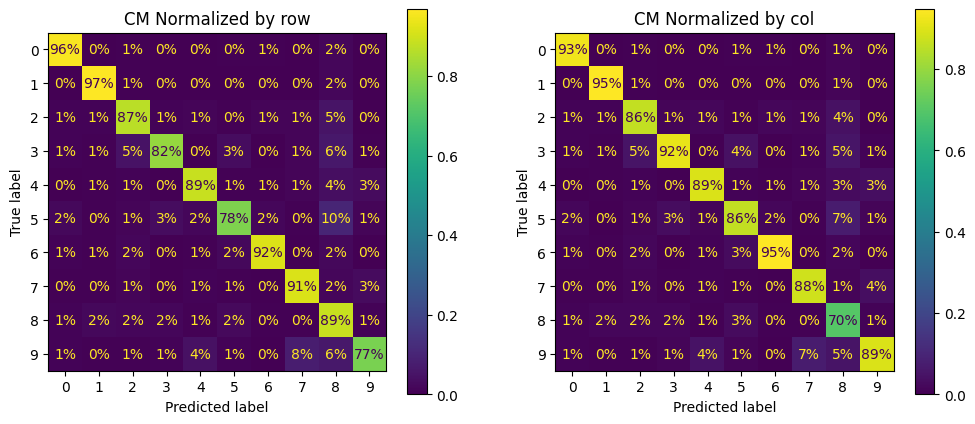

In [25]:
# normalize="true" normalize by row,  normalize="pred" normalize by col
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%', ax=axs[0])
axs[0].set_title('CM Normalized by row')
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='pred', values_format='.0%', ax=axs[1])
axs[1].set_title('CM Normalized by col')
plt.show()
# Confusion matrix is not symmetric (c[i, j] not necessarily equal to c[j, i])

It's clear that we want to minimize false 8s

Here are some possible error analysis strategies:

- try to **gather more training data for digits that look like 8s (but are not)** so that the classifier can learn to distinguish them from real
8s. 

- **engineer new features** that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). 

- **preprocess the images** (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

- **Analyzing individual errors** can also be a good way to gain insights into what your classifier is doing and why it is failing. For example

# Multi-label classification

This code creates a y_multilabel array containing two target labels for each digit
image: the first indicates whether or not the digit is large (7, 8, or 9), and the second
indicates whether or not it is odd. Then the code creates a KNeighborsClassifier
instance, which supports multilabel classification (not all classifiers do)

In [26]:
y_train_large = y_train >= '7'
y_train_odd = y_train.astype(int) % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

In [27]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [28]:
print(knn_clf.predict(X[0].reshape(1, -1)))
print('Label:', y[0])
# it gets it right! The digit '5' is indeed not large (False) and odd (True).

[[False  True]]
Label: 5


### Evaluating a multilabel classifier

There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. One approach is to measure the F1 score for each
individual label (or any other binary classifier metric discussed earlier), then simply
compute the average score.

In [29]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9782318558645072

If you wish to use a classifier that does not natively support multilabel classification,
such as `SVC`, one possible strategy is to train one model per label. However, this
strategy may have a hard time capturing the dependencies between the labels. For
example, a large digit (7, 8, or 9) is twice more likely to be odd than even, but the
classifier for the “odd” label does not know what the classifier for the “large” label
predicted. To solve this issue, the models can be organized in a chain: when a model
makes a prediction, it uses the input features plus all the predictions of the models
that come before it in the chain.

The good news is that Scikit-Learn has a class called `ClassifierChain` that does
just that!

In [30]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
# we'll just use the first 2,000 images in the training set to speed things up
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [31]:
chain_clf.predict(X[0].reshape(1, -1))
print('Label:', y[0])

Label: 5


# Multioutput Classification

It is a generalization of multilabel
classification where each label can be multiclass (i.e., it can have more than two
possible values).
To illustrate this, let's build a system that removes noise from images. It will take
as input a noisy digit image, and it will (hopefully) output a clean digit image,
represented as an array of pixel intensities, just like the MNIST images. Notice that
the classifier’s output is multilabel (one label per pixel) and each label can have
multiple values (pixel intensity ranges from 0 to 255). This is thus an example of a
multioutput classification system.

In [32]:
X_train.shape

(56000, 784)

In [33]:
np.random.seed(42)
X_train_mod = X_train + np.random.randint(0, 100, X_train.shape)
X_test_mod = X_test + np.random.randint(0, 100, X_test.shape)

y_train_mod = X_train
y_test_mod = X_test

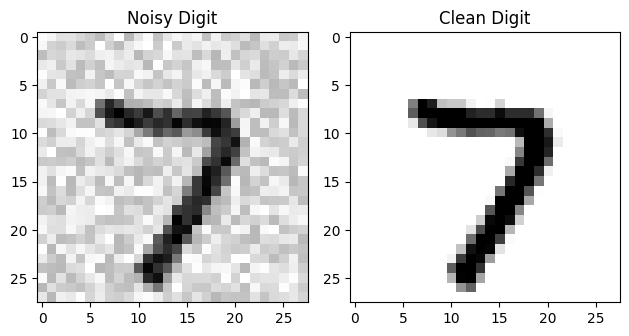

In [50]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(X_test_mod[0].reshape(28, 28), cmap='binary')
axs[0].set_title("Noisy Digit")

axs[1].imshow(y_test_mod[0].reshape(28, 28), cmap='binary')
axs[1].set_title("Clean Digit")

plt.tight_layout()
plt.show()

In [51]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

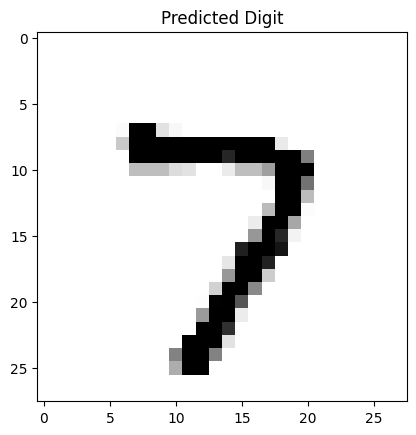

In [53]:
predicted_digit = knn_clf.predict([X_test_mod[0]])
plt.imshow(predicted_digit.reshape(28, 28), cmap='binary')
plt.title('Predicted Digit')
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential